# [2] Image Augmentation and Feature Extraction 

### Installing required libraries
Run this cell if required

In [18]:
!pip install mediapipe
!pip install opencv-python
!pip install tensorflow
!pip install keras
!pip install tqdm
!pip install scikit-learn

### Importing required libraries

In [19]:
import os
import cv2
import numpy as np
import mediapipe
from numpy import expand_dims
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from matplotlib import pyplot
from tqdm import tqdm
from IPython.display import clear_output

### Loading mediapipe modules

In [20]:
# creating a mdeiapipe hand module to detect and extract landmakrs from the hand
handsModule = mediapipe.solutions.hands

# creating a drawing module for mediapipe
drawingModule = mediapipe.solutions.drawing_utils

### Extracting hand landmarks from a image if possible
Return format [Success, landmarks] </br>
Success = boolean value denoting if extraction is successful or not </br>
Landmarks = 21 point 3D landmarks of the hand or none if hand not detected </br>

In [21]:
def get_landmarks(img):
    with handsModule.Hands(static_image_mode=True, 
                           min_detection_confidence=0.65, 
                           min_tracking_confidence=0.65, 
                           max_num_hands=1) as hands:
        #converting bgr image to rgb before conversion.
        results = hands.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
        #if landmarks is detected, extract landmarks
        if results.multi_hand_landmarks != None:
            for handLandmarks in results.multi_hand_landmarks:
                points = [] 
                #extracting landmarks into a list
                for point in handsModule.HandLandmark:
                    normalizedLandmark =  handLandmarks.landmark[point]
                    pt = [normalizedLandmark.x, normalizedLandmark.y, normalizedLandmark.z]
                    points.append(pt)
                
                #returning normalised landmarks
                if(len(points) == 21):
                    return True, np.array(points, dtype = 'float64')
                else:
                    return False, None
        else:
            #failed to capture landmarks from the image
            return False, None

### Function to create a image augment data generator using an image
#### Parameters for augmentation:
1. width shift 
2. height shift
3. rotation
4. brightness
5. zoom 

In [22]:
def create_augment_iter(img):
    samples = expand_dims(img, 0)
    datagen = ImageDataGenerator(width_shift_range=[-30,30],
                            height_shift_range=0.2,
                            rotation_range=30,
                            brightness_range=[0.4,1.4],
                            zoom_range=0.3,
                            fill_mode='nearest')
    it = datagen.flow(samples, batch_size=1)
    return it

### Setting data set path

In [23]:
path = r"datasets"
y_labels = os.listdir(path)

### Calculating the number of images per category

In [24]:
# generating path for category 'A'
a_path = os.path.join(path, y_labels[0])

# calculating the number of files in the directory 'A'
num_images = len(os.listdir(a_path))

### Testing code to check if the above functions are working, ignore this

100.jpg
(480, 480, 3) uint8
True [[ 5.47652841e-01  5.96987784e-01 -5.72866338e-05]
 [ 6.44536555e-01  5.38040400e-01 -8.84813219e-02]
 [ 6.82810962e-01  4.26069230e-01 -1.34073541e-01]
 [ 6.61099076e-01  3.28004003e-01 -1.83613151e-01]
 [ 6.10015154e-01  2.69879758e-01 -2.21723542e-01]
 [ 6.06419444e-01  3.57184976e-01 -1.30414572e-02]
 [ 5.94752550e-01  2.67458618e-01 -1.61593422e-01]
 [ 5.96042216e-01  3.41712952e-01 -2.43627101e-01]
 [ 5.99456668e-01  4.05484617e-01 -2.54671693e-01]
 [ 5.37062347e-01  3.72365475e-01 -7.48494128e-03]
 [ 5.05197108e-01  2.79867560e-01 -1.59658641e-01]
 [ 5.26336253e-01  3.70747745e-01 -2.13679999e-01]
 [ 5.48220336e-01  4.38820720e-01 -1.97337553e-01]
 [ 4.76576149e-01  4.02859032e-01 -2.59278640e-02]
 [ 4.33114409e-01  3.03759128e-01 -1.62273347e-01]
 [ 4.70557958e-01  3.93505424e-01 -1.94441840e-01]
 [ 4.98807997e-01  4.62500304e-01 -1.70970708e-01]
 [ 4.21166062e-01  4.46956813e-01 -4.72855791e-02]
 [ 3.95206690e-01  3.84469956e-01 -1.49512351e-01

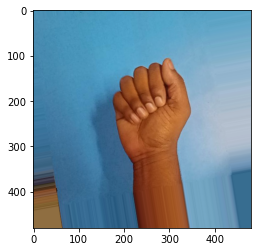

In [25]:
img = os.listdir(a_path)[2]
print(img)
img = cv2.imread(os.path.join(a_path, img))


itr = create_augment_iter(img)
img = itr.next()
img = img[0].astype('uint8')

print(img.shape, img.dtype)
ret, landmarks = get_landmarks(img)

pyplot.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
print(ret, landmarks)

### Starting the augmentation process on the entire data set

In [ ]:
# failed augmentation means landmarks extraction failed from augmented image

x_data = [] # creating list to store the landmarks
y_data = [] # creating list to store the labels for each set of landmarks

#success = 0 # number of successful images augmented
#fail = 0    # number of failed augmentations

n_cat = [] # number of images collected per category

for alphabet in y_labels: # interating through all the categories in the data set
    alphabet_path = os.path.join(path, alphabet) # obtaining the path for each category
    
    #print(alphabet_path)
    #total = 0 # total number of datapoints collected per category
    
    #looping through every image in each category
    for image in tqdm(os.listdir(alphabet_path), desc = alphabet):
        n_expand = 3  # numver of augmentations per image
        max_loss = 20 # number of failed augmentation attempts before discarding the image
        
        #loading an image from the category
        img = cv2.imread(os.path.join(alphabet_path, image))
        
        #checking if image is loaded propery or not, else move to next iteration
        if(type(img) is not np.ndarray):
            continue
        
        #creating augmentation interator for current image
        itr = create_augment_iter(img)        
        
        # looping till we get 3 augmented images or failed 20 times
        while(n_expand != 0 and max_loss != 0):
            img = itr.next() # obtaining augmented image
            img = img[0].astype('uint8') # converting the data type to unsigned 8 bit integer
            
            #obtaining landmarks from the augmented image
            ret, landmarks = get_landmarks(img)
            #total += 1
            
            if ret: # if the landmarks is extracted from the image,
                x_data.append(landmarks.reshape(7,9)) # add landmarks to the list 
                y_data.append(alphabet) # add the corrosponding category to the list
                #count = count + 1
                n_expand -= 1 # decreasing since we have a successful augmentation
                #success += 1  # 
            else:
                #fail += 1
                max_loss -= 1 # increasing value of max loss since we had a failed augmentation
        #clear_output()
    
    #n_cat.append(total)

P:  42%|████████████████████████████████▍                                            | 1263/3000 [11:56<10:08,  2.86it/s]

### Converting the landmarks and category list to numpy arrays

In [ ]:
x_dat = np.array(x_data)
y_dat = np.array(y_data)

### Checking the shape of the x_data and y_data

In [ ]:
print(x_dat.shape)
print(y_dat.shape)

### Saving the dataset as a npy file for later use

In [ ]:
np.save("x_data", x_dat)
np.save("y_data", y_dat)